# Evaluate / train models

First we import the necessary python modules and set the matplotlib parameters

In [1]:
%load_ext autoreload
%autoreload 1

%aimport dti_util

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import autokeras as ak
from dti_util import clean_ax, tile2im, decode_dam, code_dam, get_score_importances, rmse, corr, unstack_training, default
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import yaml
import seaborn as sns
from scipy import stats
import matplotlib as mpl

# Change default matplotlib
mpl.rcParams['savefig.dpi']=150
mpl.rcParams['savefig.bbox']='tight'
mpl.rcParams['savefig.pad_inches']=0.1
mpl.rcParams['axes.labelsize']=mpl.rcParams['axes.titlesize']


Set the experiment name and load the experiment setting

In [3]:
figdir = 'figs'

In [4]:
# Name of the experiment
name = 'exp-sr-sat-hr-smallpatch'

# Root of all directories used
rootdir = '/mnt/sfe-ns9602k/Julien/data'

# Directory of the experiment outputs
expdir = os.path.join(rootdir, name)

# Load experiment parameters
with open(os.path.join(expdir,'data_params.yml' )) as file:
    exp_dict = yaml.load(file, Loader=yaml.FullLoader)

    
#Add the default parameters
exp_dict = {**default, **exp_dict}
    
# Print experiments parameters
for key, value in exp_dict.items():
    print(key, ' : ', value)
    
# Set the used parameters
traindir = exp_dict['traindir']
epsi = exp_dict['epsi']
th_dam = exp_dict['th_dam']
th_sit = exp_dict['th_sit']
dsize = exp_dict['dsize']
colnames = exp_dict['colnames']
scale = exp_dict['scale']
subd = exp_dict['subd']

smooth_output  :  4
strides_test  :  2
smooth_drift  :  30
smooth_sic  :  6
smooth_sit  :  30
scale  :  False
epsi  :  None
targetname  :  h
targetfullname  :  SIT
colnames  :  ('e2_0', 'c', 'h', 'e1_0')
datadir  :  /mnt/sfe-ns9602k/Julien/data/anton/shom5km_defor_4cnn
dsize  :  7
end_train  :  400
itest  :  1
name  :  exp-sr-sat-hr-smallpatch
othernames  :  ('c',)
rootdir  :  /mnt/sfe-ns9602k/Julien/data
start_train  :  10
strides  :  20
subd  :  2
th_dam  :  0.0
th_sic  :  0.2
th_sit  :  0.0
traindir  :  /mnt/sfe-ns9602k/Julien/data/exp-sr-sat-hr-smallpatch/train


Additional setting for the model

In [5]:

# Name of the model
model_name = "long"
#model_name = "demo"

# Read model setting parameter from file
from_file = False

# pretrained model ( if False, launch a new training)
pretrained = True

# Directory to stores the model
model_dir = os.path.join(expdir, model_name)

# Create the model directory if necessary
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Dictionnary sotring all the mod setting parameters
dmod = dict()

# Default values (are used for backward compatibility)
default_mod = {
    'type': 'reg'
}

if from_file:
    # Read model parameters from yml file
    with open(os.path.join(model_dir,'model_params.yml' )) as file:
        dmod = yaml.load(file, Loader=yaml.FullLoader)   
    dmod = {**default_mod, **dmod}
else:
    # Create a yml file
    
    # Type of model (reg or class)
    dmod['type'] = 'reg'
    
    # If mod is 'class', target threshold value
    dmod['target_th'] = .95
    
    # relative size of the validation dataset
    dmod['test_size'] = 0.15

    # Seed of the train/val random split
    dmod['split_seed'] = 1

    # log_dir for tensorboard
    # log_dir is hardcoded because of NIRD toolkit, how to get the log name automatically?
    dmod['log_dir'] = "/mnt/sfe-ns9602k/.tools/deep-learn-1603280065-tensorboard/autokeras/{}-{}".format(name, model_name)

    # Shuffle score file name 
    dmod['fname_score_shuffle'] = 'shuffle_score'

    # Saliency score file name 
    dmod['fname_score_saliency'] = 'saliency_score'

    # Patience of the early stopping
    dmod['patience'] = 15 #15 #5

    # number of epochs
    dmod['epochs'] = 300

    # Number of trials of the model experiment
    dmod['max_trials'] = 50 #50 #3

    # Size of the training set (None for selecting all the training set)
    dmod['ntrain']= None #None #10000
    
    
    

    # Save the dictionary in yaml format
    with open(os.path.join(model_dir,'model_params.yml'),'w') as file:
        yaml.dump(dmod, file)

        
print ('--- MODEL CONFIGURATION ---')
for key, value in dmod.items():
    print(key, ' : ', value)

--- MODEL CONFIGURATION ---
type  :  reg
target_th  :  0.95
test_size  :  0.15
split_seed  :  1
log_dir  :  /mnt/sfe-ns9602k/.tools/deep-learn-1603280065-tensorboard/autokeras/exp-sr-sat-hr-smallpatch-long
fname_score_shuffle  :  shuffle_score
fname_score_saliency  :  saliency_score
patience  :  15
epochs  :  300
max_trials  :  50
ntrain  :  None


Define the output normalization/denormalization

In [6]:
if scale is True:
    print('Scaling the output')
    from dti_util import code_dam, decode_dam
    # Normalization function
    norm = lambda x : code_dam(x,epsi=epsi, vmin=th_dam)

    # Denormalization function
    denorm = lambda x : decode_dam(x,epsi=epsi, vmin=th_dam)
else:
    print('No scaling')

    norm = lambda x : x
    denorm = lambda x : x

No scaling


Plot options:

In [7]:
e1lim = (-5e-6,5e-6)
e2lim = (0.,1e-5)
lims = {
    'log_deformation_0': (-4, 1),
    'log_deformation_1': (-4, 1),
    'h':(th_sit,5),
    'c':(0,1),
    'd':(th_dam, 1.),
    'e1_0': e1lim,
    'e1_1': e1lim,
    'e2_0': e2lim,
    'e2_1': e2lim,
}


## 1. Load datasets

In [8]:
data = np.load(os.path.join(traindir,'train.npz'))
X = data['Xtrain']
y = data['ytrain']
mask_train = data['mask_train']
yd = denorm(y)

In [9]:
print(f"Number of training samples: {X.shape[0]}")
print(f'Size of input feature: {X.shape[1:]}')

Number of training samples: 162873
Size of input feature: (7, 7, 4)


Split the training set into train and validation

In [10]:
Xtrain, Xval, ytrain, yval = train_test_split(X.astype(np.float32), y.astype(np.float32),
                                                    test_size = dmod['test_size'],
                                                    random_state = dmod['split_seed'])

print(f"Number of training samples: {Xtrain.shape[0]}")
print(f"Number of validation samples: {Xval.shape[0]}")


Number of training samples: 138442
Number of validation samples: 24431


Text(0, 0.5, 'h (HR)')

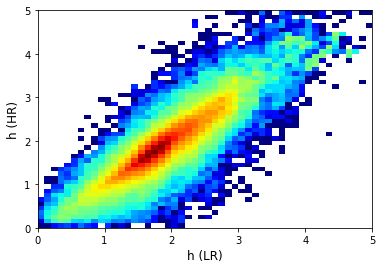

In [11]:
fig, ax = plt.subplots()
ic = colnames.index('h')

xx = Xtrain[:,dsize//2,dsize//2,ic].ravel()
yy = ytrain.ravel()

ax.hist2d(xx,yy,  50, [lims['h'],lims['h'] ], norm=matplotlib.colors.LogNorm(), cmap='jet');
ax.set_xlabel('h (LR)')
ax.set_ylabel('h (HR)')

## 2. Baseline

Two baseline are defined. Anton baselinee: ```reg_ak``` and Julien baseline: ```reg_jb```
Both baseline take the collocated deformation (scalar variable) as a predictor for the damage.
Julien's baseline is based on a polynomail regression of degree 2 based on hand-made points

In [12]:
ic = colnames.index('h')
ic2 = colnames.index('c')
def reg_bl(x):
    return x[:,dsize//2,dsize//2,ic]*x[:,dsize//2,dsize//2,ic2]



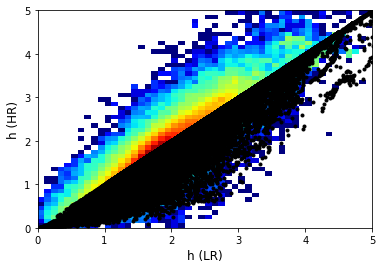

In [13]:
fig, ax = plt.subplots()
xx = Xtrain[:,dsize//2,dsize//2,0].ravel()
yy = denorm(ytrain).ravel()
ic = colnames.index('h')

xx = Xtrain[:,dsize//2,dsize//2,ic].ravel()
yy = ytrain.ravel()

ax.hist2d(xx,yy,  50, [lims['h'],lims['h'] ], norm=matplotlib.colors.LogNorm(), cmap='jet');
ax.set_xlabel('h (LR)')
ax.set_ylabel('h (HR)')

ybase = reg_bl(Xtrain).ravel()


ax.plot(xx,ybase,'.k');


## 3. Load/train model

In [14]:
if pretrained: 
    model = load_model(os.path.join(model_dir,model_name))
else: # To be used only for demo otherwise use the scrit run_script.py
   
    # Definition of the model search
    input_node = ak.ImageInput()
    out_node = ak.Normalization()(input_node)
    out_node = ak.ConvBlock()(out_node)
    #out_node2 = ak.XceptionBlock()(out_node)
    #out_node3 = ak.ResNetBlock()(out_node)
    #out_node = ak.Merge()([out_node1, out_node2, out_node3])
    output_node = ak.RegressionHead()(out_node)

    
    reg  = ak.AutoModel(
        inputs=input_node, outputs=output_node, 
        overwrite=True, 
        max_trials=dmod['max_trials'],
        project_name = 'reg',
        directory=model_dir
    )
    
    # Callback for logging
    tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir=dmod['log_dir'], histogram_freq=2)
    
    # Callback for earlystopping (important, otherwise autonatic setups are applied in a final fit)
    early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=dmod['patience'],
    min_delta=1e-4,
    verbose=1,
    restore_best_weights=True
)
    
    # Fit the model
    reg.fit(
        Xtrain[:dmod['ntrain']],
        ytrain[:dmod['ntrain']],
        validation_data=(Xval, yval),
        epochs = dmod['epochs'],
        callbacks=[tensorboard_callback, early_stopping_monitor]
        )
    
    # Export and save the best model
    model = reg.export_model()
    model.save(os.path.join(model_dir,model_name), save_format="tf")

In [15]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 7, 4)]         0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 7, 7, 4)           0         
_________________________________________________________________
normalization (Normalization (None, 7, 7, 4)           9         
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          1184      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 32)         

## 4. Evaluate the model on the validation set

In [16]:
# Evaluation of the model (on the normalized output)
model.evaluate(Xval, yval, batch_size=20)


1222/1222 [==============================] - 2s 1ms/step - loss: 0.0437 - mean_squared_error: 0.0437


[0.04368457943201065, 0.04368457943201065]

In [17]:
# Model prediction on the validation dataset (denormalized)

ypredict = denorm(model.predict(Xval))


In [18]:
# Simple regressions predictions

y_bl = reg_bl(Xval)

# Denormalized ground truth (validation dataset)
yval_d = denorm(yval)

Scatter plots of the different predictors

Text(0.5, 1.0, 'Basline')

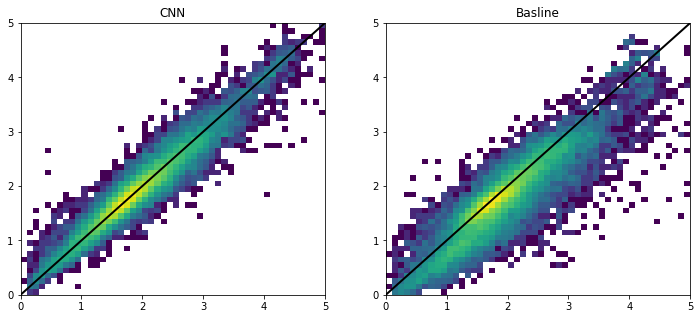

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
xylims = lims['h']

ax[0].hist2d(yval_d.ravel(),ypredict.ravel(),  50, [xylims, xylims], norm=matplotlib.colors.LogNorm()),
ax[0].plot(xylims,xylims,'k',linewidth=2)
ax[0].set_title('CNN')

ax[1].hist2d(yval_d.ravel(),y_bl.ravel(),  50, [xylims, xylims], norm=matplotlib.colors.LogNorm()),
ax[1].plot(xylims,xylims,'k',linewidth=2)
ax[1].set_title('Basline')



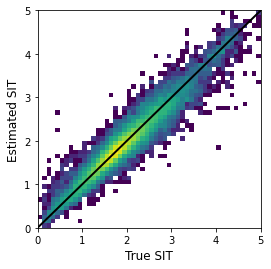

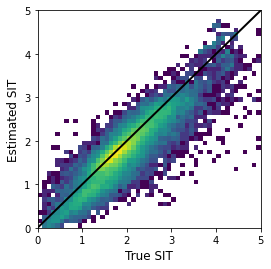

In [20]:
fig, ax = plt.subplots(figsize=(4,4))
ax.hist2d(yval_d.ravel(),ypredict.ravel(),  50, [xylims, xylims], norm=matplotlib.colors.LogNorm()),
ax.plot(xylims,xylims,'k',linewidth=2)
ax.set_xlabel('True SIT')
ax.set_ylabel('Estimated SIT')
fig.savefig(os.path.join(figdir,'sp_nn.png'))

fig, ax = plt.subplots(figsize=(4,4))
ax.hist2d(yval_d.ravel(),y_bl.ravel(),  50, [xylims, xylims], norm=matplotlib.colors.LogNorm()),
ax.plot(xylims,xylims,'k',linewidth=2)
ax.set_xlabel('True SIT')
ax.set_ylabel('Estimated SIT')
fig.savefig(os.path.join(figdir,'sp_bl.png'))

Compute quantitative scores

In [21]:

# Mask in case one likes to look at only a subset of the dataset:
#mask=(yval_d>.96) & (yval_d<.98)
mask= None 

# Compute and print RMSE
rmse_nn = rmse(yval_d[mask], ypredict[mask])
rmse_bl = rmse(yval_d[mask], y_bl[mask])
print(f'RMSE NN: {rmse_nn:.2e}\nRMSE bl: {rmse_bl:.2e}')

RMSE NN: 1.09e+00
RMSE bl: 3.89e-01


In [22]:
# Compute and print correlation
corr_nn = corr(yval_d[mask].ravel(), ypredict[mask].ravel())
corr_bl = corr(yval_d[mask].ravel(), y_bl[mask].ravel())
print(f'corr NN: {corr_nn:.2f}\ncorr bl: {corr_bl:.2f}\n')

corr NN: 0.96
corr bl: 0.89



In [23]:
# Compute and print bias
bias_nn = np.mean(ypredict[mask]-yval_d[mask])
bias_bl = np.mean(y_bl[mask]-yval_d[mask])
print(f'bias NN: {bias_nn:.2e}\nbias bl: {bias_bl:.2e}')

bias NN: -8.44e-03
bias bl: -1.60e-01


Compute statics per bins of of damage

In [24]:
#Bins to compute
cbins = np.arange(0,5,.5)

# Compute binned rmse
delta_nn =  ypredict.ravel() - yval_d.ravel()
bin_rmse_nn, bin_edges, binnumber = stats.binned_statistic(yval_d.ravel(),
               np.square(delta_nn) , statistic='mean', bins=cbins)

delta_bl = y_bl.ravel() - yval_d.ravel()
bin_rmse_bl, bin_edges, binnumber = stats.binned_statistic(yval_d.ravel(),
               np.square(delta_bl) , statistic='mean', bins=cbins)


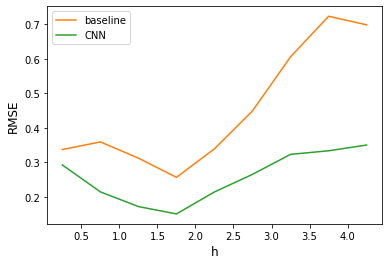

In [25]:
# Plot binned RMSE
fig, ax = plt.subplots()
cbin = .5 *(bin_edges[:-1]+bin_edges[1:])
ax.plot(cbin,np.sqrt(bin_rmse_bl), color='C1',label='baseline')
ax.plot(cbin,np.sqrt(bin_rmse_nn), color='C2',label='CNN')
ax.set_xlabel('h')
ax.set_ylabel('RMSE')
ax.legend();

histogram of errors

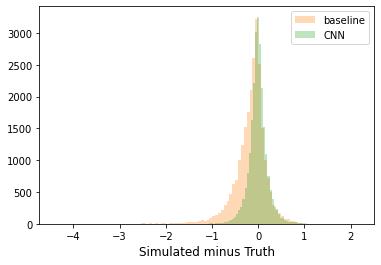

In [26]:
bins = 100

fig, ax = plt.subplots()
ax.hist(delta_bl, bins, alpha=0.3, label='baseline',color='C1');
ax.hist(delta_nn, bins, alpha=0.3, label='CNN',color='C2');
ax.legend();
ax.set_xlabel('Simulated minus Truth');

Histogram of values for the different models:

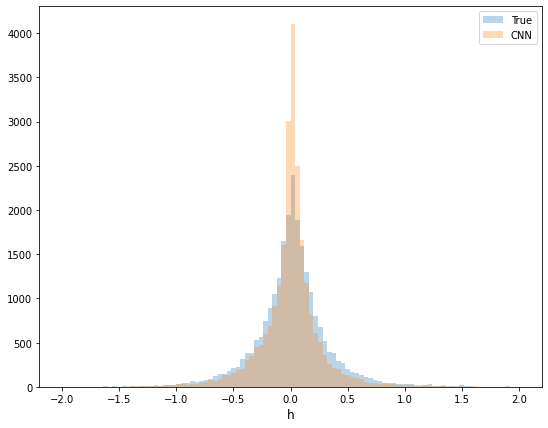

In [27]:
bins = 100
fig, ax = plt.subplots(figsize=(9,7))
ic = colnames.index('h')

plt.hist(yval_d.ravel()-Xval[...,dsize//2,dsize//2,ic], bins,  (-2,2), alpha=0.3, label='True')
#plt.hist(y_bl.ravel()-Xval[...,7,7,ic], bins,  (-2,2), alpha=0.3, label='baseline')
plt.hist(ypredict.ravel()-Xval[...,dsize//2,dsize//2,ic], bins,  (-2,2), alpha=0.3, label='CNN')

plt.xlabel('h')
plt.legend()

## 5 Plot a test image

Free unused memory and load data

In [28]:
try:
    del Xtrain, ytrain, X, y
except:
    pass
data_test = np.load(os.path.join(traindir,'test.npz'))

Extract data

In [29]:
Xtest = data_test['Xtest']
ytest = denorm(data_test['ytest'])
mask_test = data_test['mask_test']
shape_original = data_test['shape_original']
ntest, ny, nx = shape_original
print (f'Size of the output image: {ny}x{nx}')

Size of the output image: 400x500


Predict the outuput for the CNN model and the 2 baselines

In [30]:
ypred_test = denorm(model.predict(Xtest))
y_bl_test = reg_bl(Xtest)


Unstack the tile to obtain the full image

In [31]:
X2, y2_test = unstack_training(Xtest, ytest, mask_test, ny=ny, nx=nx, strides=2, subd=subd, squeezey=True)
X2, y2_pred = unstack_training(Xtest, ypred_test, mask_test, ny=ny, nx=nx, strides=2, subd=subd, squeezey=True)
X2, y2_bl = unstack_training(Xtest, y_bl_test, mask_test, ny=ny, nx=nx, strides=2, subd=subd, squeezey=True)

y2_test = y2_test.squeeze()
y2_pred = y2_pred.squeeze()
y2_bl = y2_bl.squeeze()


In [32]:
y2_test.shape

(197, 247)

Plot the test image (In the error plots, values below the threshold are masked)

Text(0.5, 1.0, 'NN')

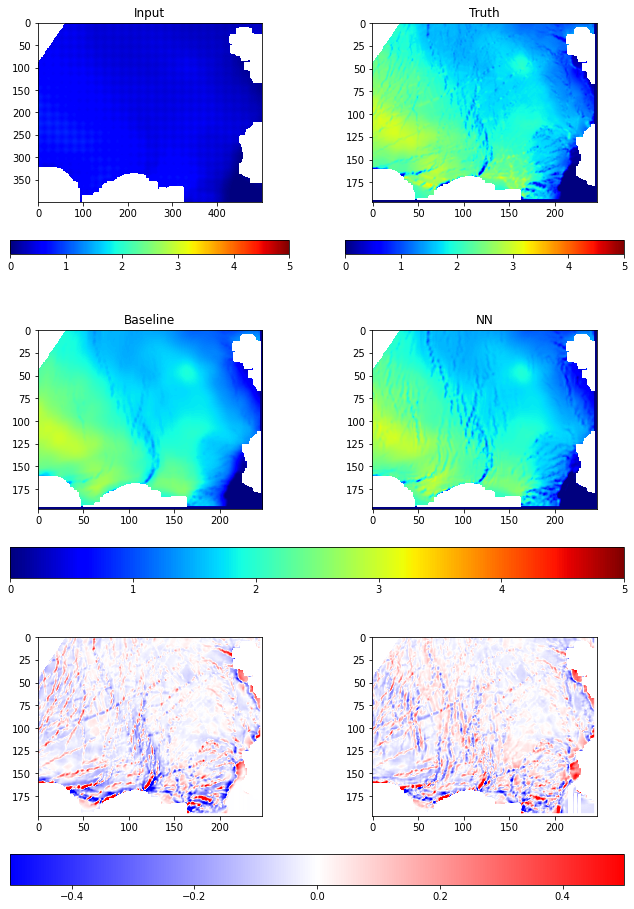

In [33]:
fig, ax = plt.subplots(ncols=2,nrows=3,figsize=(11,16))
delta_bl = y2_bl-y2_test
delta_pred = y2_pred-y2_test
ic = colnames.index('h')

#Mask values below the threshold
delta_bl[y2_test<th_dam] = np.nan
delta_pred[y2_test<th_dam] = np.nan
vmin,vmax = lims['h']
defor = ax[0,0].imshow(X2[0,...,ic],vmin=vmin,vmax=vmax, cmap='jet')
#vmin,vmax = -1,1

dam = ax[0,1].imshow(y2_test,vmin=vmin, vmax = vmax,cmap='jet')
ax[1,0].imshow(y2_bl,vmin=vmin, vmax=vmax,cmap='jet')
ax[1,1].imshow(y2_pred,vmin=vmin, vmax=vmax,cmap='jet')
err = ax[2,0].imshow(delta_bl,vmin=-0.5,vmax=0.5,cmap=plt.get_cmap('bwr'))
ax[2,1].imshow(delta_pred,vmin=-0.5,vmax=0.5,cmap=plt.get_cmap('bwr'))

fig.colorbar(err, ax=ax[2,:].ravel().tolist(),orientation='horizontal');
fig.colorbar(dam, ax=ax[1,:].ravel().tolist(),orientation='horizontal');
fig.colorbar(defor, ax=ax[0,0],orientation='horizontal');
fig.colorbar(dam, ax=ax[0,1],orientation='horizontal');

ax[0,0].set_title('Input')
ax[0,1].set_title('Truth')
ax[1,0].set_title('Baseline')
ax[1,1].set_title('NN')

Plot the input features

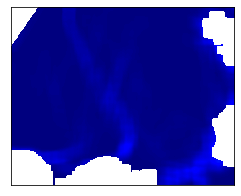

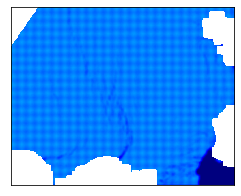

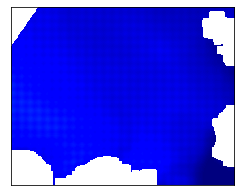

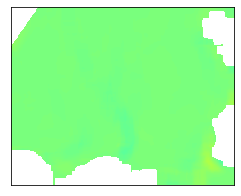

In [34]:
for ic,col in enumerate(colnames):
    fig, ax = plt.subplots(figsize=(4,4))
    #ax.set_title(col)
    vmin, vmax = lims[col]
    im = ax.imshow(X2[0,...,ic],vmin=vmin,vmax=vmax, cmap='jet')
    clean_ax([ax])
    #fig.colorbar(im, ax=ax,orientation='horizontal');
    fig.savefig(os.path.join(figdir,f'{col}_test.png'))

Plot separatley outputs

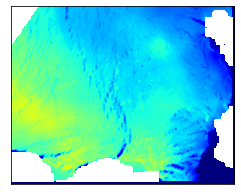

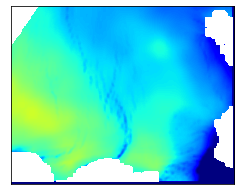

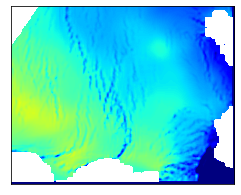

In [35]:
vmin, vmax = lims['h']

fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(y2_test,vmin=vmin,vmax=vmax, cmap='jet')
clean_ax([ax])
fig.savefig(os.path.join(figdir,f'h_hr.png'))

fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(y2_bl, vmin=vmin,vmax=vmax, cmap='jet')
clean_ax([ax])
fig.savefig(os.path.join(figdir,f'h_bl.png'))

fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(y2_pred,vmin=vmin,vmax=vmax, cmap='jet')
clean_ax([ax])
fig.savefig(os.path.join(figdir,f'h_nn.png'))

Scatter plots

Text(0.5, 1.0, 'Baseline')

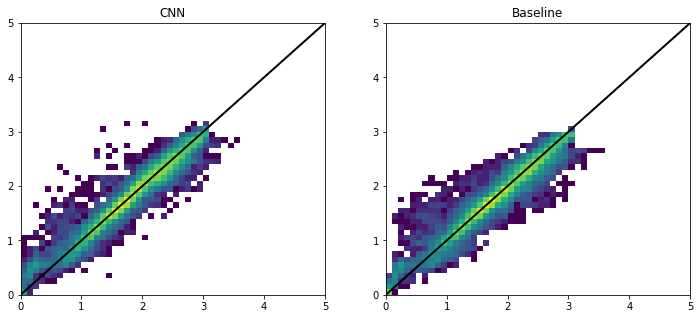

In [37]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
xylims = lims['h']

ax[0].hist2d(ytest.ravel(),ypred_test.ravel(),  50, [xylims, xylims], norm=matplotlib.colors.LogNorm()),
ax[0].plot(xylims,xylims,'k',linewidth=2)
ax[0].set_title('CNN')

ax[1].hist2d(ytest.ravel(),y_bl_test.ravel(),  50, [xylims, xylims], norm=matplotlib.colors.LogNorm()),
ax[1].plot(xylims,xylims,'k',linewidth=2)
ax[1].set_title('Baseline')




In [38]:
# Compute and print correlation
mask= ytest>0
corr_nn = corr(ytest[mask].ravel(), ypred_test[mask].ravel())
corr_bl = corr(ytest[mask].ravel(), y_bl_test[mask].ravel())
print(f'corr NN: {corr_nn:.2f}\ncorr bl: {corr_bl:.2f}')

corr NN: 0.98
corr bl: 0.97


In [39]:
# Compute and print RMSE
rmse_nn = rmse(ytest[mask].ravel(), ypred_test[mask].ravel())
rmse_bl = rmse(ytest[mask].ravel(), y_bl_test[mask].ravel())
print(f'RMSE NN: {rmse_nn:.2e}\nRMSE bl: {rmse_bl:.2e}')

RMSE NN: 1.18e-01
RMSE bl: 1.26e-01


In [40]:
from dti_util import im2tile


In [41]:
ytest_tiled, _ = im2tile(y2_test[np.newaxis,...,np.newaxis],None)
ynn_tiled, _ = im2tile(y2_pred[np.newaxis,...,np.newaxis],None)
ybl_tiled, _ = im2tile(y2_bl[np.newaxis,...,np.newaxis],None)

print(ytest_tiled.shape)
print(ynn_tiled.shape)
print(ybl_tiled.shape)


(38579, 25, 25, 1)
(38579, 25, 25, 1)
(38579, 25, 25, 1)


Text(0.5, 1.0, 'NN')

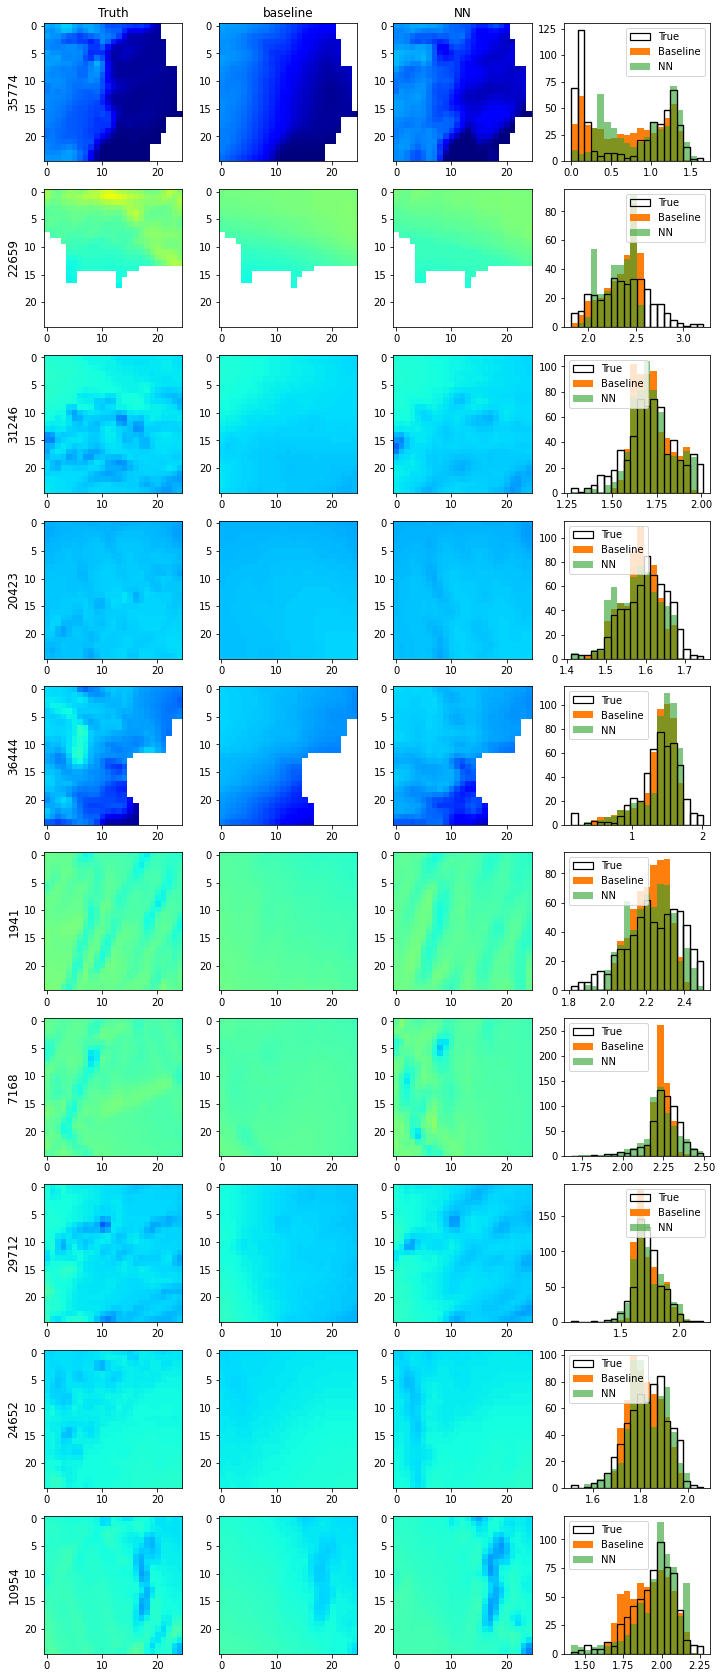

In [42]:
# Draw 10 examples
nex = 10
ntiles = ytest_tiled.shape[0]
np.random.seed(113)
iperm = np.random.choice(ntiles, nex, replace=False)
vmin,vmax = lims['h']
bins=np.arange(0,5,0.2)

fig, ax = plt.subplots(nrows=nex, ncols=4,  figsize=(12, nex*3))

for i in range(nex):
    ax[i,0].imshow(ytest_tiled[iperm[i],...,0],vmin=vmin,vmax=vmax, cmap='jet')
    ax[i,1].imshow(ybl_tiled[iperm[i],...,0],vmin=vmin,vmax=vmax, cmap='jet')
    ax[i,2].imshow(ynn_tiled[iperm[i],...,0],vmin=vmin,vmax=vmax, cmap='jet')
    _,bins,_ = ax[i,3].hist(ytest_tiled[iperm[i]].ravel(),bins=20,edgecolor='black', fc=(0,0,0,0), linewidth=1.2,label='True')

    ax[i,3].hist(ybl_tiled[iperm[i]].ravel(),bins=bins,color='C1',label='Baseline')
    ax[i,3].hist(ynn_tiled[iperm[i]].ravel(),bins=bins,alpha=.6,color='C2',label='NN')
    ax[i,3].hist(ytest_tiled[iperm[i]].ravel(),bins=bins,edgecolor='black', fc=(0,0,0,0), linewidth=1.2)
    ax[i,3].legend()
    ax[i,0].set_ylabel(iperm[i])
plt.legend()
ax[0,0].set_title('Truth')
ax[0,1].set_title('baseline')
ax[0,2].set_title('NN')

Selected zooms

IndexError: index 96501 is out of bounds for axis 0 with size 38579

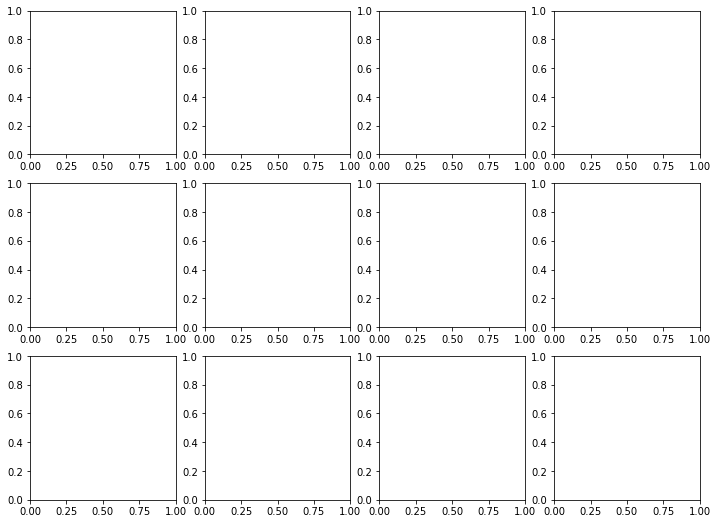

In [43]:
fig, ax = plt.subplots(nrows=3, ncols=4,  figsize=(12, 3*3))
lzoom=[96501, 112152, 150669]

for i in range(3):
    ax[i,1].imshow(ytest_tiled[lzoom[i],...,0],vmin=vmin,vmax=vmax, cmap='jet')
    ax[i,0].imshow(ybl_tiled[lzoom[i],...,0],vmin=vmin,vmax=vmax, cmap='jet')
    ax[i,2].imshow(ynn_tiled[lzoom[i],...,0],vmin=vmin,vmax=vmax, cmap='jet')
    _,bins,_ = ax[i,3].hist(ytest_tiled[lzoom[i]].ravel(),bins=20,edgecolor='black', fc=(0,0,0,0), linewidth=1.2,label='True')

    ax[i,3].hist(ybl_tiled[lzoom[i]].ravel(),bins=bins,color='C1',label='Baseline')
    ax[i,3].hist(ynn_tiled[lzoom[i]].ravel(),bins=bins,alpha=.6,color='C2',label='NN')
    ax[i,3].hist(ytest_tiled[lzoom[i]].ravel(),bins=bins,edgecolor='black', fc=(0,0,0,0), linewidth=1.2)
    ax[i,3].legend()
plt.legend()
ax[0,1].set_title('Truth')
ax[0,0].set_title('baseline')
ax[0,2].set_title('NN')
fig.savefig(os.path.join(figdir,'zoom.png'))

Print patches

In [44]:
Xtest_tiled, _ = im2tile(X2,None,dsize=dsize)
print(Xtest_tiled.shape, ntiles)

(187596, 15, 15, 4) 178976


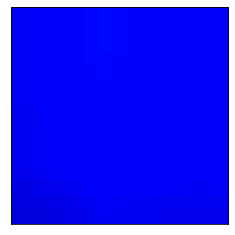

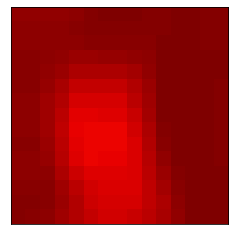

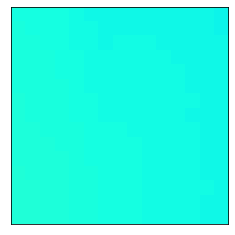

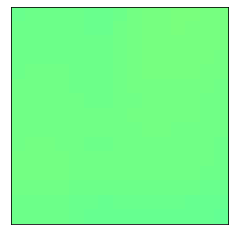

In [45]:
i=iperm[7]
for ic,col in enumerate(colnames):
    fig, ax = plt.subplots(figsize=(4,4))
    #ax.set_title(col)
    vmin, vmax = lims[col]
    im = ax.imshow(Xtest_tiled[i,...,ic],vmin=vmin,vmax=vmax, cmap='jet')
    clean_ax([ax])
    #fig.colorbar(im, ax=ax,orientation='horizontal');
    fig.savefig(os.path.join(figdir,f'{col}_patch.png'))

In [46]:
hbins = [.5, 1., 1.5, 2., 3., 4.]

hbin = .1
htest = np.nan*np.ones((ntiles,len(hbins)))
hbl = np.nan*np.ones((ntiles,len(hbins)+1))
hnn = np.nan*np.ones((ntiles,len(hbins)+1))

for i, hbin  in enumerate(hbins):
    norm = 1.0*np.sum(~np.isnan(ytest_tiled), axis=(1,2,3))
    norm[norm<500]=np.nan
    htest[:,i] = np.sum(ytest_tiled<hbin,axis=(1,2,3))/norm
    norm = 1.0*np.sum(~np.isnan(ybl_tiled), axis=(1,2,3))
    norm[norm<500]=np.nan
    hbl[:,i] = np.sum(ybl_tiled<hbin,axis=(1,2,3))/norm
    norm = 1.0*np.sum(~np.isnan(ynn_tiled), axis=(1,2,3))
    norm[norm<500]=np.nan
    hnn[:,i] = np.sum(ynn_tiled<hbin,axis=(1,2,3))/norm

In [1]:
nbins = len(bins)
from scipy.stats import chisquare
from tqdm.notebook import tqdm
for i in tqdm(range(ytest_tiled.shape[0])):
    histbl,_=np.histogram(ybl_tiled[i].ravel(),density=True,bins=bins)
    histnn,_=np.histogram(ynn_tiled[i].ravel(),density=True,bins=bins)
    hist,_=np.histogram(ytest_tiled[i].ravel(),density=True,bins=bins)
    if nbins>10:
        hbl[i,-1], _ = chisquare(histbl[hist>0]/nbins,hist[hist>0]/nbins)
        hnn[i,-1], _ = chisquare(histnn[hist>0]/nbins,hist[hist>0]/nbins)

NameError: name 'bins' is not defined

In [ ]:
qtest = np.nan*np.ones((ntiles))
qbl = np.nan*np.ones((ntiles))
qnn = np.nan*np.ones((ntiles))
q0 = 0.1
for i in tqdm(range(ytest_tiled.shape[0])):
    qtest[i]=np.quantile(ytest_tiled[i].ravel(),q=q0)
    qnn[i]=np.quantile(ynn_tiled[i].ravel(),q=q0)
    qbl[i]=np.quantile(ybl_tiled[i].ravel(),q=q0)


In [ ]:
nbins = len(bins)
from scipy.stats import kstest
from tqdm.notebook import tqdm
for i in tqdm(range(ytest_tiled.shape[0])):

        hbl[i,-1], _ = kstest(ybl_tiled[i].ravel(),ytest_tiled[i].ravel())
        hnn[i,-1], _ = kstest(ynn_tiled[i].ravel(),ytest_tiled[i].ravel())

In [ ]:
a,b = chisquare(hbl[h>0]/nbins,h[h>0]/nbins)
hbl.shape

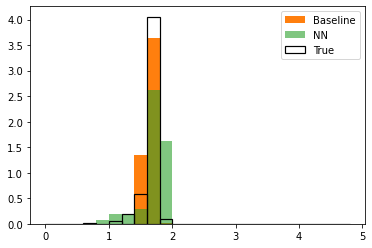

In [106]:
bins=np.arange(0,5,0.2)
h1,_,_=plt.hist(ybl_tiled[iperm[4]].ravel(),density=True,bins=bins,color='C1',label='Baseline')
h2,_,_=plt.hist(ynn_tiled[iperm[4]].ravel(),density=True,bins=bins,alpha=.6,color='C2',label='NN')
h3,_,_=plt.hist(ytest_tiled[iperm[4]].ravel(),density=True,bins=bins,edgecolor='black', fc=(0,0,0,0), linewidth=1.2,label='True')

plt.legend()

In [ ]:
_, htest2 = tile2im(ytest_tiled, htest)
_, hbl2 = tile2im(ytest_tiled, hbl)
_, hnn2 = tile2im(ytest_tiled, hnn)

_, qtest2 = tile2im(ytest_tiled, qtest[...,np.newaxis])
_, qbl2 = tile2im(ytest_tiled, qbl[...,np.newaxis])
_, qnn2 = tile2im(ytest_tiled, qnn[...,np.newaxis])

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(12,5))

it=1

ax[0].imshow(hbl2[0,...,it],vmin=0,vmax=.1, cmap='jet')
ax[1].imshow(htest2[0,...,it],vmin=0,vmax=.1, cmap='jet')
im=ax[2].imshow(hnn2[0,...,it],vmin=0,vmax=.1, cmap='jet')
clean_ax(ax)
ax[0].set_title('BASELINE')
ax[1].set_title('Truth')
ax[2].set_title('NN')
fig.colorbar(im,ax=ax,orientation='horizontal', extend='max')
fig.savefig(os.path.join(figdir,f'all_sit_lt_{hbins[it]}.png'))

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(12,5))


ax[0].imshow(qbl2[0,...,0],vmin=0,vmax=2, cmap='jet')
ax[1].imshow(qtest2[0,...,0],vmin=0,vmax=2, cmap='jet')
im=ax[2].imshow(qnn2[0,...,0],vmin=0,vmax=2, cmap='jet')
clean_ax(ax)
ax[0].set_title('BASELINE')
ax[1].set_title('Truth')
ax[2].set_title('NN')
fig.colorbar(im,ax=ax,orientation='horizontal', extend='max')
fig.savefig(os.path.join(figdir,f'all_sit_quant_{q0}.png'))

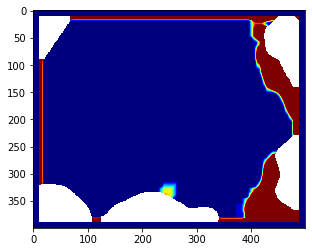

In [93]:
plt.imshow(hbl2[0,...,1],vmin=0,vmax=.1, cmap='jet')

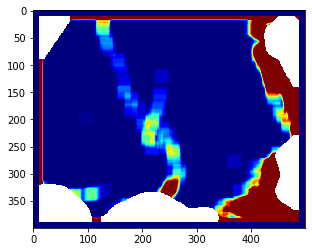

In [94]:
plt.imshow(hnn2[0,...,1],vmin=0,vmax=.1, cmap='jet')


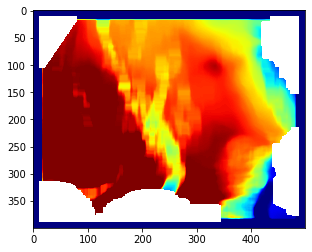

In [106]:
plt.imshow(qnn2[0,...,0],vmin=0,vmax=2, cmap='jet')


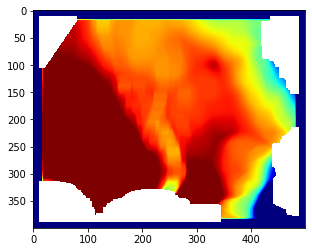

In [105]:
plt.imshow(qbl2[0,...,0],vmin=0,vmax=2, cmap='jet')


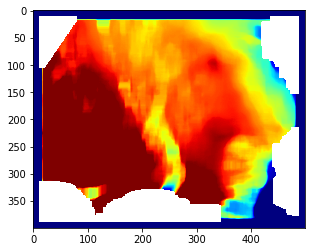

In [108]:
plt.imshow(qtest2[0,...,0],vmin=0,vmax=2, cmap='jet')


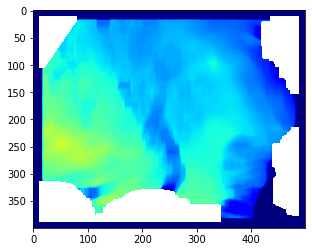

In [100]:
plt.imshow(qtest2[0,...,0],vmin=0,vmax=5, cmap='jet')


## 6. Interpretability of the CNN model

### 6.1 Feature importance using feature permutation
Let consider a n feature predictors $f(x^1,\cdots,x^n)$
We can compute the base score of the model on a set of data (e.g. validation dataset) $(X_k,y_k)$:
where $X_k = (x_k^1,\cdots,x_k^n)$
$$
S^o = {\rm score}\left(f(X_{1:K},y_{1:K})\right)
$$
In the following the score used is the correlation.

To evaluate the impact of a predictor feature, we randomly shuffle the input feature in the validation dataset. Shuffled feature is denoted $\tilde{x}^i$, and we define $X^i_k = (x_k^1,\cdots,\tilde{x}_k^i,\cdots,x_k^n)$.

The importance of the feature is evaluated by the decrease after calculated the new score:
$$
S^i = {\rm score}\left(f(X_{1:K}^i,y_{1:K})\right)
$$



In [57]:
# Define input and output features od the validation set
X_sk = Xval
y_sk = denorm(yval)


# Try to compute 


# Define the score
def score_nn (X, y):
    ypredict = denorm(model.predict(X))
    return corr(y.ravel(), ypredict.ravel())

# Compute the score of each feature (the computation is done n_iter times corresponding to n_iter different random shuffle)
base_score, score_decreases = get_score_importances(score_nn, 
                                                    X_sk, 
                                                    y_sk, 
                                                    n_iter=10, 
                                                    pre_shuffle=True
                                                   )

# Compute the mean importance of each input feature
score_mean = np.mean(score_decreases, axis=0)
score_std = np.std(score_decreases, axis=0)


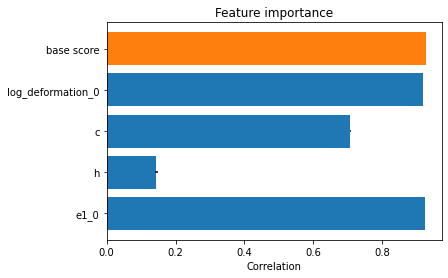

In [58]:
# Plot the importance
y_pos = np.arange(len(colnames)+1)
fig, ax = plt.subplots()

ax.barh(y_pos[1:], base_score-score_mean, xerr=score_std, align='center')
ax.barh(y_pos[0],base_score)
ax.set_yticks(y_pos);
ax.set_yticklabels(('base score',)+colnames)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Correlation')
ax.set_title('Feature importance');

### 6.2 Saliency maps
Let's consier the predictor $y=f(x^1,\cdots,x^n)$

For each input feature image $x^i$, we compute the saliency map defined by
$$
s = \frac{\partial y}{\partial x^i}
$$
The value of the saliency map represents the sensitivity of the output of the model with respect to this input.

Finally, we compute the average saliency map over multiple samples

In [59]:
from tf_keras_vis.saliency import Saliency
saliency = Saliency(model,
                    model_modifier=None,
                    clone=False)

In [161]:
#Number of sample used to calculate the saliency map
n_sample = 5000

# Define the loss for the gradient computation
def loss(output):
    return tuple(output[i] for i in range(n_sample))

# Compute the saliency map for each input feature (keepdims=True)
saliency_map = saliency(loss, Xval[:n_sample], keepdims=True)

# Compute the average saliency map
saliency_absmean = np.abs(saliency_map).mean(axis=0)

# To be used to normalize the saliency map with the standard deviation
sigma_in = np.sqrt(model.layers[2].variance.numpy())


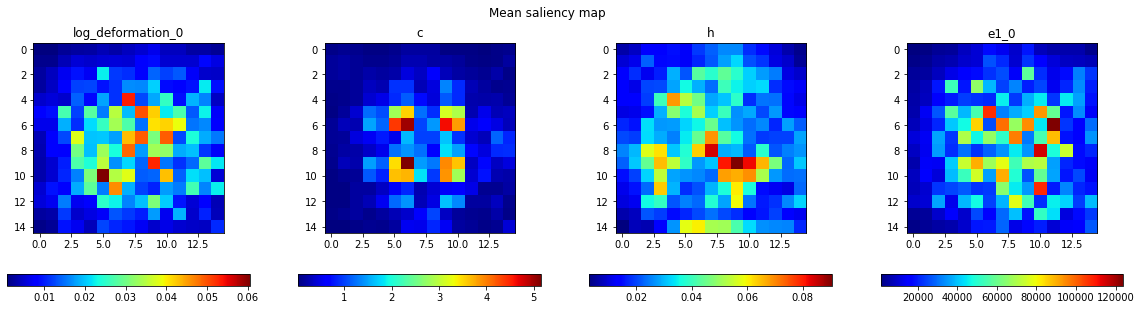

In [162]:
nc = len(exp_dict['colnames'])
vmax = saliency_absmean.max()
fig, ax = plt.subplots(ncols=nc,figsize=(5*nc,5))
for i in range(nc):
    # Comment to have a common scale
    vmax = saliency_absmean[...,i].max()
    im = ax[i].imshow(saliency_absmean[...,i], cmap='jet', vmax = vmax)
    ax[i].set_title(exp_dict['colnames'][i])
    fig.colorbar(im, ax=ax[i],orientation='horizontal');

# fig.colorbar(im, ax=ax.ravel().tolist(),orientation='horizontal');
fig.suptitle ('Mean saliency map');

In [50]:
#TODO ?
#- saliency binned
#- saliency good prediction/bad predictions